In [1]:
#core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

#tensorflow & keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2     
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2, VGG19, ResNet50, InceptionV3
#from keras_squeezenet import SqueezeNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet import MobileNet
from keras import optimizers, callbacks, regularizers
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D,GlobalMaxPooling2D, GlobalAveragePooling2D,concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Layer
#from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,f1_score,recall_score,precision_score, ConfusionMatrixDisplay
from PIL import Image
import json
from collections import defaultdict
import pickle
from tqdm import tqdm

2024-05-15 06:30:56.188452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 06:30:56.188539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 06:30:56.360705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [3]:
# Remove rows with only "No Finding" label
df = df[df['Finding Labels'] != 'No Finding']
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,0.168000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,Consolidation|Pleural_Thickening,7,30786,61,F,AP,3056,2544,0.139000,0.139000,NaN
112100,00030789_000.png,Infiltration,0,30789,52,F,PA,2021,2021,0.194311,0.194311,NaN
112106,00030793_000.png,Mass|Nodule,0,30793,58,F,PA,2021,2021,0.194311,0.194311,NaN
112108,00030795_000.png,Pleural_Thickening,0,30795,53,F,PA,2021,2021,0.194311,0.194311,NaN


In [4]:
# Convert 'Finding Labels' into sets
df['Finding Labels'] = df['Finding Labels'].str.split('|').apply(set)

# Extract all unique labels
all_labels = set(label for labels in df['Finding Labels'] for label in labels)
all_labels = sorted(all_labels)

#Create a mapping between labels and indices
label_to_index_mapping = {label: idx for idx, label in enumerate(all_labels)}

# Convert the labels into binary columns (one-hot encoding)
for label in all_labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)


df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,{Cardiomegaly},0,1,58,M,PA,2682,2749,0.143000,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,"{Cardiomegaly, Emphysema}",1,1,58,M,PA,2894,2729,0.143000,...,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,"{Effusion, Cardiomegaly}",2,1,58,M,PA,2500,2048,0.168000,...,1,0,0,0,0,0,0,0,0,0
4,00000003_000.png,{Hernia},0,3,81,F,PA,2582,2991,0.143000,...,0,0,0,1,0,0,0,0,0,0
5,00000003_001.png,{Hernia},1,3,74,F,PA,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,"{Consolidation, Pleural_Thickening}",7,30786,61,F,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,1,0,0
112100,00030789_000.png,{Infiltration},0,30789,52,F,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,0
112106,00030793_000.png,"{Nodule, Mass}",0,30793,58,F,PA,2021,2021,0.194311,...,0,0,0,0,0,1,1,0,0,0
112108,00030795_000.png,{Pleural_Thickening},0,30795,53,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,1,0,0


In [5]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [6]:
# Create a dictionary mapping image index to one-hot encoded labels    
image_to_labels = {}
for _, row in df.iterrows():
    image_index = row['Image Index']
    # Convert the binary label columns to a list of values
    labels = [row[label] for label in all_labels]
    # Map the image index to the list of binary labels
    image_to_labels[image_index] = labels

In [7]:
len(image_to_labels)

51759

In [8]:
label_to_index_mapping

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural_Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13}

In [9]:
# Open the JSON file
with open('/kaggle/input/xray-classification-files/file_paths_to_labels.json', 'r') as file:
    # Load the JSON data into a dictionary
    file_paths_to_labels = json.load(file)

In [9]:
base_dir = '/kaggle/input/data'
folders = [f'images_{str(i).zfill(3)}' for i in range(1, 13)]

# Define the image_to_labels dictionary
# image_to_labels = {'00000001_000.png': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#                   '00000001_001.png': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#                   '00000001_002.png': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#                   '00000003_000.png': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
#                   }

# Create a new dictionary to map file paths to labels
file_paths_to_labels = {}

# Iterate through each image index and label in the images_to_labels dictionary
for image_filename, label in image_to_labels.items():
    # Iterate through each folder to find the image file
    for folder in folders:
        # Construct the full file path for the current folder and image filename
        image_path = os.path.join(base_dir, folder, 'images', image_filename)
        
        # Check if the file exists
        if os.path.exists(image_path):
            # Add the file path and label to the new dictionary
            file_paths_to_labels[image_path] = label
            # Break out of the loop since we've found the correct path
            break
            
# Define the path where you want to save the dictionary
# output_path = '/kaggle/working/file_paths_to_labels.json'

# # Save the dictionary as a JSON file
# with open(output_path, 'w') as json_file:
#     json.dump(file_paths_to_labels, json_file)

In [10]:
len(file_paths_to_labels)

51759

In [11]:
# List to store images (x) and labels (y)
images = []
labels = []

# Specify the target image size and color mode
target_size = (128, 128)  # Example: resize images to 224x224
color_mode = 'rgb'  # Use 'rgb' for color images

# Loop through the dictionary
for file_path, label in tqdm(file_paths_to_labels.items()):
    # Load the image from the file path
    try:
        image = load_img(file_path, target_size=target_size, color_mode=color_mode)
        # Convert the image to a numpy array
        image = img_to_array(image)
        # Append the image and label to their respective lists
        images.append(image)
        labels.append(label)
    except Exception as e:
        # Handle exceptions (e.g., file not found)
        print(f"Error loading image {file_path}: {e}")

# Convert the lists to numpy arrays
x = np.array(images)
y = np.array(labels)

# Save the x array to a .npy file
np.save('/kaggle/working/x.npy', x)
# Save the y array to a .npy file
np.save('/kaggle/working/y.npy', y)

# Check the shapes of the arrays
print(f"x shape: {x.shape}")  # Should be (num_images, height, width, channels)
print(f"y shape: {y.shape}")  # Should be (num_images, num_labels)

#Your x and y are now ready to be used for training a deep learning model

100%|██████████| 51759/51759 [25:17<00:00, 34.11it/s]


x shape: (51759, 128, 128, 3)
y shape: (51759, 14)


In [11]:
x = np.load('/kaggle/input/xray-classification-files/x.npy')
y = np.load('/kaggle/input/xray-classification-files/y.npy')

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(38819, 64, 64, 3)
(38819, 14)
(12940, 64, 64, 3)
(12940, 14)


## Mobile Net

In [13]:
base_mobilenet_model = MobileNet(input_shape =  (64,64,3), 
                                 include_top = False, weights = None)
mobileNet_model = Sequential()
mobileNet_model.add(base_mobilenet_model)
mobileNet_model.add(GlobalAveragePooling2D())
mobileNet_model.add(Dropout(0.5))
mobileNet_model.add(Dense(512))
mobileNet_model.add(Dropout(0.5))
mobileNet_model.add(Dense(len(all_labels), activation = 'sigmoid'))
mobileNet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
mobileNet_model.build(input_shape=(None, 64, 64, 3))
mobileNet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_64 (Functional)  │ (None, 2, 2, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,760,846 (14.35 MB)

 Trainable params: 3,738,958 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [14]:
weight_path="/kaggle/working/{}.weights.h5".format('mobieNet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=False, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=30)
callbacks_list = [checkpoint, early]

In [21]:
mobileNet_history = mobileNet_model.fit(x_train, y_train, validation_data = (x_test, y_test), 
                                  epochs = 50, 
                                  callbacks = callbacks_list)

Epoch 1/50
   7/1214 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - binary_accuracy: 0.7154 - loss: 0.6678 - mae: 0.3016   

I0000 00:00:1715553868.345612     181 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715553868.390874     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - binary_accuracy: 0.8738 - loss: 0.3689 - mae: 0.1835

W0000 00:00:1715553897.643883     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715553901.428326     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/mobieNet.weights.h5


W0000 00:00:1715553905.281816     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 67s 31ms/step - binary_accuracy: 0.8738 - loss: 0.3688 - mae: 0.1835 - val_binary_accuracy: 0.8878 - val_loss: 0.3065 - val_mae: 0.1850
Epoch 2/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8861 - loss: 0.3084 - mae: 0.1784
Epoch 2: saving model to /kaggle/working/mobieNet.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8861 - loss: 0.3084 - mae: 0.1783 - val_binary_accuracy: 0.8398 - val_loss: 0.3412 - val_mae: 0.1744
Epoch 3/50
1213/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8868 - loss: 0.3005 - mae: 0.1758
Epoch 3: saving model to /kaggle/working/mobieNet.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8868 - loss: 0.3005 - mae: 0.1758 - val_binary_accuracy: 0.8881 - val_loss: 0.2968 - val_mae: 0.1685
Epoch 4/50
1213/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8875 - loss: 0.2971 - mae: 0.1740
Epoch 4: saving model to /kaggle/working/mobieN

In [81]:
y_pred_mobileNet = mobileNet_model.predict(x_test,verbose = True)

 38/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

W0000 00:00:1715559251.859386     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


W0000 00:00:1715559254.927761     182 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


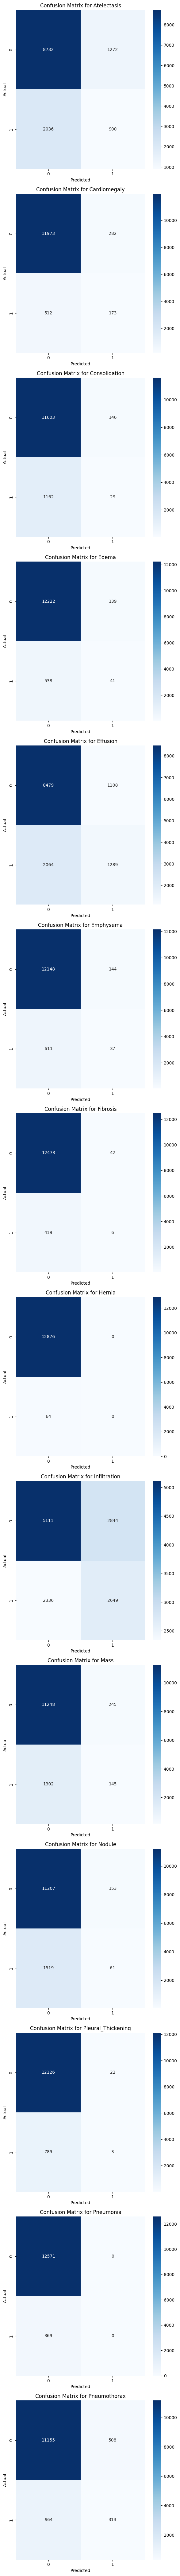

In [82]:
def plot_confusion_matrices(y_test, y_pred, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 1, figsize=(6, 6 * num_classes))
    
    # Ensure y_pred is in binary form (0 or 1) based on a threshold, e.g., 0.5
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    
    for i, class_name in enumerate(class_names):
        # Calculate confusion matrix for the current class
        cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
        
        # Plot confusion matrix as a heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {class_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
# Get class names from the DataFrame
class_names = list(all_labels)

# Plot confusion matrices for each class
plot_confusion_matrices(y_test, y_pred_mobileNet, class_names)

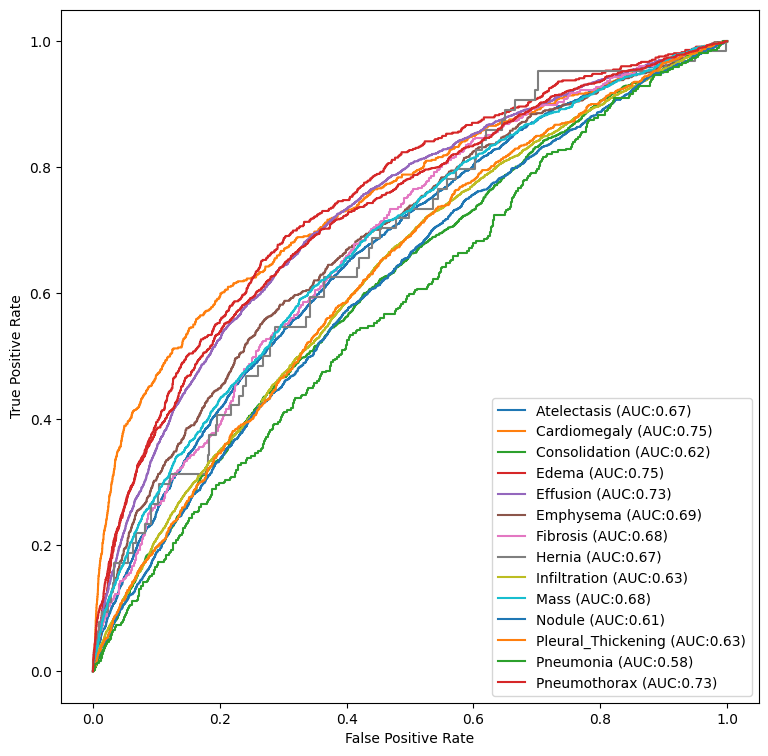

In [83]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred_mobileNet[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('mobilenet.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


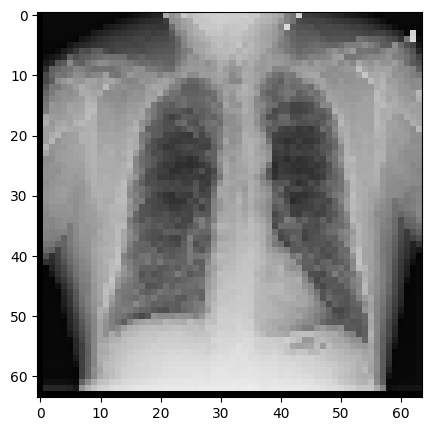

Original Labels: ['Infiltration']
Predicted Labels: ['Infiltration']


In [159]:
# Choose a random test image
test_img_number = random.randint(0, len(x_test)-1)
test_img = x_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Get the ground truth labels
ground_truth = y_test[test_img_number]

# Make predictions
mobilenet_prediction = mobileNet_model.predict(test_img_input)

# Threshold for considering a label as predicted
threshold = 0.5

# Get the predicted labels based on the threshold
predicted_labels = [all_labels[i] for i in range(len(all_labels)) if mobilenet_prediction[0][i] > threshold]

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.show()

# Print original and predicted labels
print("Original Labels:", [all_labels[i] for i in range(len(all_labels)) if ground_truth[i] == 1])
print("Predicted Labels:", predicted_labels)

## EfficientNet

In [24]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the EfficientNetB0 model pre-trained on ImageNet without the top (fully connected) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Create a new model on top of the EfficientNetB0 base model
efficientnet_model = Sequential()

# Add the EfficientNetB0 base model to the new model
efficientnet_model.add(base_model)

# Add a global spatial average pooling layer
efficientnet_model.add(GlobalAveragePooling2D())

# Add a fully connected layer with 1024 units and ReLU activation
efficientnet_model.add(Dense(1024, activation='relu'))

# Add an output layer with 14 units (for 14 labels) and sigmoid activation for multi-label classification
efficientnet_model.add(Dense(14, activation='sigmoid'))

efficientnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
efficientnet_model.build(input_shape=(None, 64, 64, 3))


# Print model summary
efficientnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,375,665 (20.51 MB)

 Trainable params: 5,333,642 (20.35 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [27]:
# Define paths and callbacks
checkpoint_path = "/kaggle/working/efficientnet_model.weights.h5"

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss',mode=min, patience=20, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',mode=min, patience=10, verbose=1, factor=0.3, min_lr=0.000001)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_freq='epoch', verbose=1)

# Combine all callbacks into a list
callbacks_list = [early_stop, learning_rate_reduction, cp_callback]

In [28]:
efficientnet_history = efficientnet_model.fit(x_train,y_train, epochs=50,
                               validation_data = (x_test, y_test),
                              callbacks=callbacks_list
                              )

Epoch 1/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.8986 - loss: 0.2584 - mae: 0.1526
Epoch 1: saving model to /kaggle/working/efficientnet_model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - binary_accuracy: 0.8986 - loss: 0.2584 - mae: 0.1526 - val_binary_accuracy: 0.8912 - val_loss: 0.2761 - val_mae: 0.1655 - learning_rate: 0.0010
Epoch 2/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.8993 - loss: 0.2551 - mae: 0.1510
Epoch 2: saving model to /kaggle/working/efficientnet_model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - binary_accuracy: 0.8993 - loss: 0.2551 - mae: 0.1510 - val_binary_accuracy: 0.8953 - val_loss: 0.2720 - val_mae: 0.1603 - learning_rate: 0.0010
Epoch 3/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.9024 - loss: 0.2483 - mae: 0.1473
Epoch 3: saving model to /kaggle/working/efficientnet_model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - binary_accuracy: 0.9024 - lo

In [29]:
y_pred_efficientnet = efficientnet_model.predict(x_test,verbose = True)

 22/405 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

W0000 00:00:1715757818.707698     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


405/405 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step


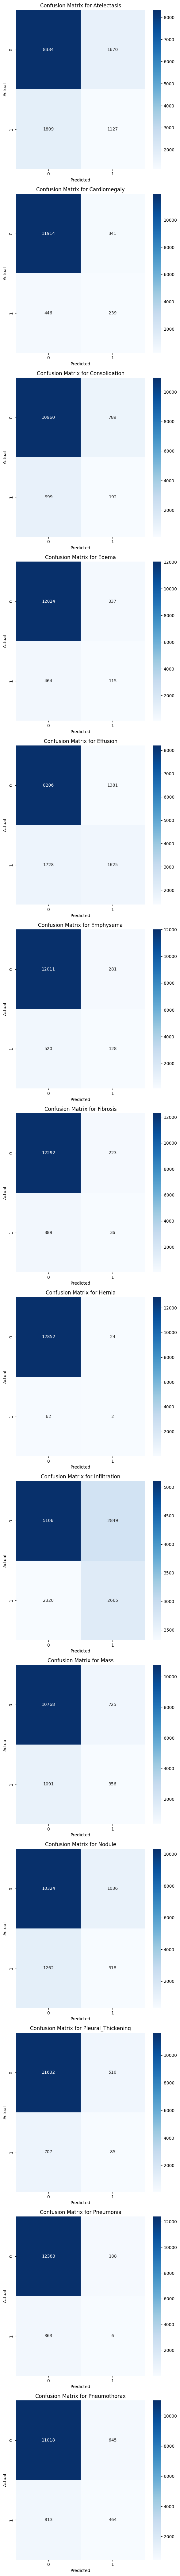

In [30]:
def plot_confusion_matrices(y_test, y_pred, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 1, figsize=(6, 6 * num_classes))
    
    # Ensure y_pred is in binary form (0 or 1) based on a threshold, e.g., 0.5
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    
    for i, class_name in enumerate(class_names):
        # Calculate confusion matrix for the current class
        cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
        
        # Plot confusion matrix as a heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix for {class_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
# Get class names from the DataFrame
class_names = list(all_labels)

# Plot confusion matrices for each class
plot_confusion_matrices(y_test, y_pred_efficientnet, class_names)

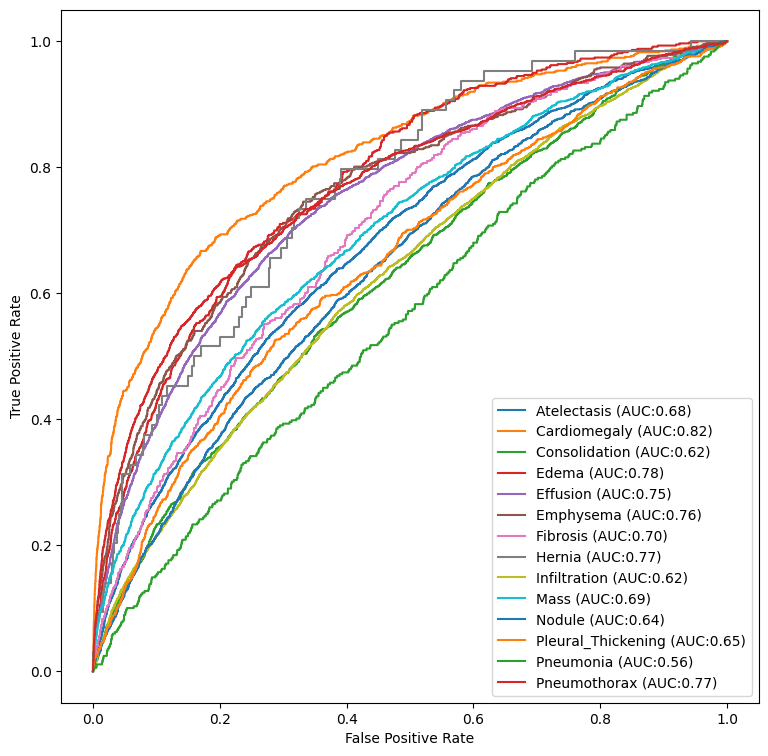

In [32]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred_efficientnet[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('efficientnet.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


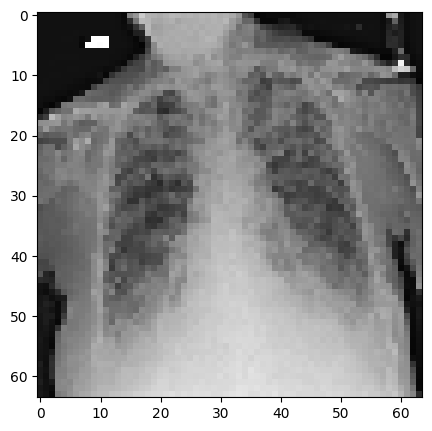

Original Labels: ['Effusion', 'Infiltration']
Predicted Labels: ['Effusion', 'Infiltration']


In [36]:
# Choose a random test image
test_img_number = random.randint(0, len(x_test)-1)
test_img = x_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Get the ground truth labels
ground_truth = y_test[test_img_number]

# Make predictions
efficientnet_prediction = efficientnet_model.predict(test_img_input)

# Threshold for considering a label as predicted
threshold = 0.5

# Get the predicted labels based on the threshold
predicted_labels = [all_labels[i] for i in range(len(all_labels)) if efficientnet_prediction[0][i] > threshold]

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.show()

# Print original and predicted labels
print("Original Labels:", [all_labels[i] for i in range(len(all_labels)) if ground_truth[i] == 1])
print("Predicted Labels:", predicted_labels)

## ELM

In [44]:
from scipy.sparse import random as sparse_random_matrix
from sklearn.linear_model import RidgeClassifier


class ELM:
    def __init__(self, n_hidden_units):
        self.n_hidden_units = n_hidden_units
        self.input_weights = None
        self.bias = None
        self.activation_func = np.tanh  # You can change the activation function if needed
    
    def fit(self, X, y, epochs=1, validation_data=None):
        n_samples, n_features = X.shape
        n_classes = y.shape[1]
        history = {'loss': [], 'val_loss': []}  # Store training history
        for epoch in range(epochs):
            # Generate random weights for the input layer
            self.input_weights = sparse_random_matrix(self.n_hidden_units, n_features, density=0.001).toarray()
            # Add a bias term
            self.bias = np.random.randn(self.n_hidden_units)
            # Compute hidden layer output
            H = self.activation_func(np.dot(X, self.input_weights.T) + self.bias)
            # Solve the output weights using Ridge regression
            self.output_weights = np.zeros((self.n_hidden_units, n_classes))
            for i in range(n_classes):
                clf = RidgeClassifier()
                clf.fit(H, y[:, i])
                self.output_weights[:, i] = clf.coef_
            # Compute training loss
            y_pred = self.predict(X)
            loss = np.mean(np.square(y - y_pred))
            history['loss'].append(loss)
            # Compute validation loss if provided
            if validation_data:
                X_val, y_val = validation_data
                y_val_pred = self.predict(X_val)
                val_loss = np.mean(np.square(y_val - y_val_pred))
                history['val_loss'].append(val_loss)
                print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f} - val_loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f}")
        return history

    def predict(self, X, threshold=0.5):
        H = self.activation_func(np.dot(X, self.input_weights.T) + self.bias)
        y_pred = np.dot(H, self.output_weights)
        y_pred_binary = (y_pred > threshold).astype(int)
        return y_pred_binary

In [15]:
elm_model = ELM(n_hidden_units=1000)
elm_history = elm_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
   7/1214 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - binary_accuracy: 0.5169 - loss: 0.9763 - mae: 0.4917  

I0000 00:00:1715736679.387360     194 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715736679.413126     194 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.8568 - loss: 0.3594 - mae: 0.2065

W0000 00:00:1715736706.573183     195 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715736709.122277     196 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - binary_accuracy: 0.8568 - loss: 0.3594 - mae: 0.2065 - val_binary_accuracy: 0.8878 - val_loss: 0.2960 - val_mae: 0.1715 - learning_rate: 0.1000
Epoch 2/50
   1/1214 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - binary_accuracy: 0.8973 - loss: 0.2612 - mae: 0.1585

W0000 00:00:1715736712.235061     197 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1211/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.8869 - loss: 0.2986 - mae: 0.1741
Epoch 2: saving model to /kaggle/working/model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8869 - loss: 0.2986 - mae: 0.1741 - val_binary_accuracy: 0.8881 - val_loss: 0.2947 - val_mae: 0.1751 - learning_rate: 0.1000
Epoch 3/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8873 - loss: 0.2956 - mae: 0.1739
Epoch 3: saving model to /kaggle/working/model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8873 - loss: 0.2956 - mae: 0.1739 - val_binary_accuracy: 0.8888 - val_loss: 0.2893 - val_mae: 0.1700 - learning_rate: 0.1000
Epoch 4/50
1213/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.8879 - loss: 0.2930 - mae: 0.1727
Epoch 4: saving model to /kaggle/working/model.weights.h5
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - binary_accuracy: 0.8879 - loss: 0.2930 - mae: 0.1727 - val_binary_accuracy: 0.

In [51]:
y_pred_elm = elm_model.predict(x_test, verbose = 1)

405/405 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


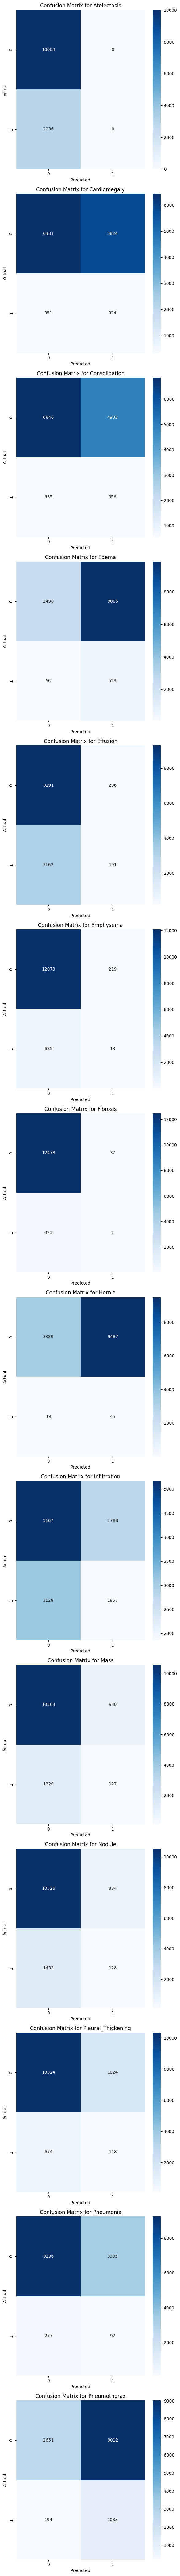

In [52]:
plot_confusion_matrices(y_test, y_pred_elm, class_names)

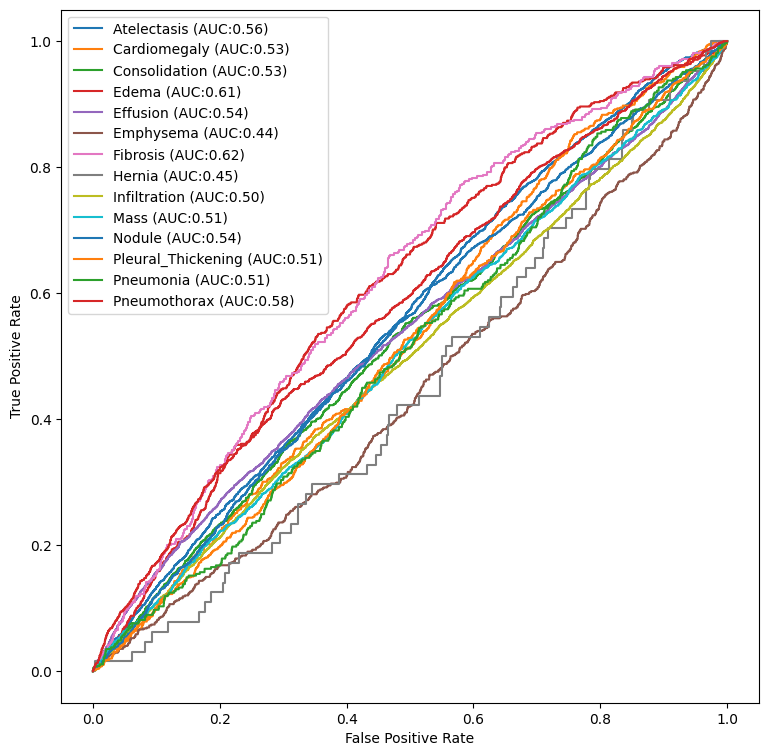

In [49]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred_elm[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('elm.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


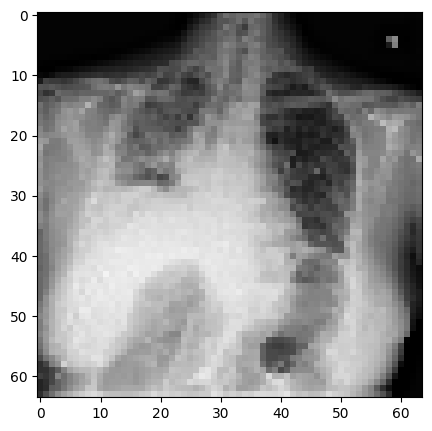

Original Labels: ['Atelectasis', 'Effusion', 'Infiltration', 'Pneumothorax']
Predicted Labels: ['Cardiomegaly', 'Edema', 'Hernia', 'Infiltration', 'Pneumothorax']


In [74]:
test_img_number = random.randint(0, len(x_test)-1)
test_img = x_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Get the ground truth labels
ground_truth = y_test[test_img_number]

# Make predictions
elm_prediction = model.predict(test_img_input)

# Threshold for considering a label as predicted
threshold = 0.5

# Get the predicted labels based on the threshold
predicted_labels = [all_labels[i] for i in range(len(all_labels)) if elm_prediction[0][i] > threshold]

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.show()

# Print original and predicted labels
print("Original Labels:", [all_labels[i] for i in range(len(all_labels)) if ground_truth[i] == 1])
print("Predicted Labels:", predicted_labels)

## Ensembling

In [76]:
from keras.models import load_model
mobileNet_model.load_weights('/kaggle/input/xray-classification-files/mobilenet_model.weights.h5')
efficient_model.load_weights('/kaggle/input/xray-classification-files/efficientnet_model.weights.h5')
elm_model_load = load_model('/kaggle/input/xray-classification-files/pretrained_model.h5')

# Predictions for each model
mobileNet_prediction = mobileNet_model.predict(x_test)
efficientnet_prediction = efficientnet_model.predict(x_test)
elm_prediction = elm_model_load.predict(x_test)

# Ensemble averaging
ensemble_avg_prediction = (mobilenet_prediction + efficientnet_prediction + elm_prediction) / 3

# Define weights for weighted averaging
weights = [0.6, 0.2, 0.2]

# Weighted averaging
weighted_avg_prediction = (weights[0] * mobilenet_prediction +
                           weights[1] * efficientnet_prediction +
                           weights[2] * elm_prediction)

# Apply threshold for binary prediction
threshold = 0.5
ensemble_avg_binary_prediction = np.where(ensemble_avg_prediction > threshold, 1, 0)
weighted_avg_binary_prediction = np.where(weighted_avg_prediction > threshold, 1, 0)

# Define function to convert binary predictions to one-hot encoded format
def binary_to_one_hot(binary_predictions):
    return np.eye(14)[binary_predictions]

# Convert binary predictions to one-hot encoded format
ensemble_avg_one_hot_prediction = binary_to_one_hot(ensemble_avg_binary_prediction)
weighted_avg_one_hot_prediction = binary_to_one_hot(weighted_avg_binary_prediction)

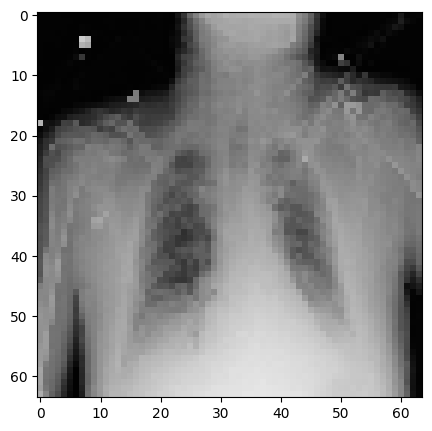

Original Labels: ['Effusion', 'Infiltration']
Predicted Labels: ['Effusion']


In [87]:
test_img_number = random.randint(0, len(x_test)-1)
test_img = x_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

# Get the ground truth labels
ground_truth = y_test[test_img_number]

# Threshold for considering a label as predicted
threshold = 0.5

# Get the predicted labels based on the threshold
predicted_labels = [all_labels[i] for i in range(len(all_labels)) if weighted_avg_prediction[0][i] > threshold]

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.show()

# Print original and predicted labels
print("Original Labels:", [all_labels[i] for i in range(len(all_labels)) if ground_truth[i] == 1])
print("Predicted Labels:", predicted_labels)

## Rough Code

In [46]:
from tensorflow.keras.applications import DenseNet121
# create the base pre-trained model
base_model = DenseNet121(weights='/kaggle/input/xray-classification-files/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer 
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [47]:
model.load_weights("/kaggle/input/xray-classification-files/pretrained_model.h5")

In [131]:
x_train_scaled = x_train.astype('float32') / 255.0

In [138]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

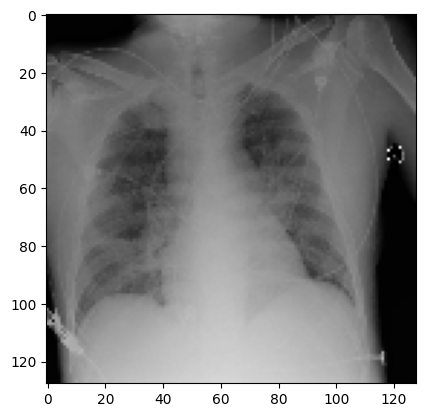

In [12]:
plt.imshow(x_train[0])
plt.show()

In [133]:
x_train_scaled[0]

array([[[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.05882353, 0.05882353, 0.05882353],
        [0.02745098, 0.02745098, 0.02745098],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.10588235, 0.10588235, 0.10588235],
        [0.05098039, 0.05098039, 0.05098039],
        [0.01568628, 0.01568628, 0.01568628]],

       ...,

       [[0.01568628, 0.01568628, 0.01568628],
        [0.01176471, 0.01176471, 0.01176471],
        [0.18431373, 0

In [137]:
x_train[0]

array([[[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [ 7.,  7.,  7.],
        [ 1.,  1.,  1.],
        [ 2.,  2.,  2.]],

       [[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [15., 15., 15.],
        [ 7.,  7.,  7.],
        [ 2.,  2.,  2.]],

       [[ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        [ 2.,  2.,  2.],
        ...,
        [27., 27., 27.],
        [13., 13., 13.],
        [ 4.,  4.,  4.]],

       ...,

       [[ 4.,  4.,  4.],
        [ 3.,  3.,  3.],
        [47., 47., 47.],
        ...,
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.]],

       [[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [35., 35., 35.],
        ...,
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.]],

       [[ 4.,  4.,  4.],
        [ 3.,  3.,  3.],
        [23., 23., 23.],
        ...,
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 4.,  4.,  4.]]

In [20]:
optimizers_list = [('sgd',optimizers.SGD( learning_rate=.1) ),
                   ('sgd_momentum',optimizers.SGD(learning_rate=.1, momentum=.9) ),
                   ('adagrad',optimizers.Adagrad()),
                   ('adadelta',optimizers.Adadelta()),
                   ('adam', optimizers.Adam()) 
                  ]

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [early]

Epoch 1/50
  10/1214 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - binary_accuracy: 0.8903 - loss: 0.2995 - mae: 0.1761 

W0000 00:00:1715154014.155251     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - binary_accuracy: 0.8871 - loss: 0.3033 - mae: 0.1766

W0000 00:00:1715154036.940601     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715154040.315571     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - binary_accuracy: 0.8871 - loss: 0.3033 - mae: 0.1766 - val_binary_accuracy: 0.8878 - val_loss: 0.3206 - val_mae: 0.1733
Epoch 2/50
  11/1214 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - binary_accuracy: 0.8876 - loss: 0.3085 - mae: 0.1833

W0000 00:00:1715154043.185612     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - binary_accuracy: 0.8879 - loss: 0.2992 - mae: 0.1756 - val_binary_accuracy: 0.8862 - val_loss: 0.2988 - val_mae: 0.1772
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - binary_accuracy: 0.8879 - loss: 0.2970 - mae: 0.1746 - val_binary_accuracy: 0.8878 - val_loss: 0.3176 - val_mae: 0.1847
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - binary_accuracy: 0.8882 - loss: 0.2959 - mae: 0.1746 - val_binary_accuracy: 0.8832 - val_loss: 0.2969 - val_mae: 0.1779
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - binary_accuracy: 0.8885 - loss: 0.2944 - mae: 0.1733 - val_binary_accuracy: 0.8887 - val_loss: 0.2973 - val_mae: 0.1766
Epoch 6/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - binary_accuracy: 0.8885 - loss: 0.2939 - mae: 0.1732 - val_binary_accuracy: 0.8884 - val_loss: 0.2951 - val_mae: 0.1711
Epoch 7/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - binary_accuracy: 0.8897 - loss: 0.2901 - mae: 0.1708 - val_bina

W0000 00:00:1715154265.230723     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.8871 - loss: 0.2992 - mae: 0.1748

W0000 00:00:1715154291.369253     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715154294.765804     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - binary_accuracy: 0.8871 - loss: 0.2992 - mae: 0.1748 - val_binary_accuracy: 0.8860 - val_loss: 0.2998 - val_mae: 0.1744
Epoch 2/50
   9/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - binary_accuracy: 0.8815 - loss: 0.3006 - mae: 0.1801

W0000 00:00:1715154297.727391     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8863 - loss: 0.3019 - mae: 0.1760 - val_binary_accuracy: 0.8840 - val_loss: 0.2981 - val_mae: 0.1696
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8875 - loss: 0.2965 - mae: 0.1737 - val_binary_accuracy: 0.8890 - val_loss: 0.2916 - val_mae: 0.1703
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.8881 - loss: 0.2926 - mae: 0.1720 - val_binary_accuracy: 0.8889 - val_loss: 0.2964 - val_mae: 0.1746
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.8883 - loss: 0.2909 - mae: 0.1713 - val_binary_accuracy: 0.8899 - val_loss: 0.2852 - val_mae: 0.1694
Epoch 6/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8898 - loss: 0.2842 - mae: 0.1676 - val_binary_accuracy: 0.8894 - val_loss: 0.2882 - val_mae: 0.1664
Epoch 7/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8900 - loss: 0.2814 - mae: 0.1665 - val_bina

W0000 00:00:1715154694.848202     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - binary_accuracy: 0.9012 - loss: 0.2503 - mae: 0.1498

W0000 00:00:1715154720.867969     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715154724.298992     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - binary_accuracy: 0.9012 - loss: 0.2503 - mae: 0.1498 - val_binary_accuracy: 0.8920 - val_loss: 0.2776 - val_mae: 0.1562
Epoch 2/50
  10/1214 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - binary_accuracy: 0.9024 - loss: 0.2406 - mae: 0.1471

W0000 00:00:1715154727.124066     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9020 - loss: 0.2480 - mae: 0.1487 - val_binary_accuracy: 0.8921 - val_loss: 0.2775 - val_mae: 0.1558
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9029 - loss: 0.2467 - mae: 0.1478 - val_binary_accuracy: 0.8920 - val_loss: 0.2773 - val_mae: 0.1556
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9028 - loss: 0.2462 - mae: 0.1475 - val_binary_accuracy: 0.8919 - val_loss: 0.2777 - val_mae: 0.1551
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9034 - loss: 0.2453 - mae: 0.1468 - val_binary_accuracy: 0.8919 - val_loss: 0.2778 - val_mae: 0.1549
Epoch 6/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9033 - loss: 0.2440 - mae: 0.1461 - val_binary_accuracy: 0.8918 - val_loss: 0.2781 - val_mae: 0.1547
Epoch 7/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9035 - loss: 0.2436 - mae: 0.1456 - val_bina

W0000 00:00:1715154878.788540     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.9045 - loss: 0.2421 - mae: 0.1448

W0000 00:00:1715154909.444712     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715154912.930107     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - binary_accuracy: 0.9045 - loss: 0.2421 - mae: 0.1448 - val_binary_accuracy: 0.8918 - val_loss: 0.2785 - val_mae: 0.1544
Epoch 2/50
   9/1214 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - binary_accuracy: 0.9020 - loss: 0.2315 - mae: 0.1419

W0000 00:00:1715154915.765806     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - binary_accuracy: 0.9042 - loss: 0.2416 - mae: 0.1445 - val_binary_accuracy: 0.8917 - val_loss: 0.2787 - val_mae: 0.1539
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - binary_accuracy: 0.9044 - loss: 0.2421 - mae: 0.1446 - val_binary_accuracy: 0.8914 - val_loss: 0.2790 - val_mae: 0.1540
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - binary_accuracy: 0.9044 - loss: 0.2415 - mae: 0.1442 - val_binary_accuracy: 0.8916 - val_loss: 0.2788 - val_mae: 0.1541
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - binary_accuracy: 0.9047 - loss: 0.2405 - mae: 0.1439 - val_binary_accuracy: 0.8916 - val_loss: 0.2793 - val_mae: 0.1537
Epoch 1/50
  10/1214 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - binary_accuracy: 0.8933 - loss: 0.2672 - mae: 0.1552 

W0000 00:00:1715155024.512916     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - binary_accuracy: 0.8931 - loss: 0.2741 - mae: 0.1605

W0000 00:00:1715155052.560021     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715155056.049097     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 61s 28ms/step - binary_accuracy: 0.8931 - loss: 0.2741 - mae: 0.1605 - val_binary_accuracy: 0.8917 - val_loss: 0.2801 - val_mae: 0.1631
Epoch 2/50
   9/1214 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - binary_accuracy: 0.8970 - loss: 0.2632 - mae: 0.1552

W0000 00:00:1715155059.091468     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - binary_accuracy: 0.8946 - loss: 0.2697 - mae: 0.1591 - val_binary_accuracy: 0.8910 - val_loss: 0.2805 - val_mae: 0.1640
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - binary_accuracy: 0.8950 - loss: 0.2682 - mae: 0.1584 - val_binary_accuracy: 0.8902 - val_loss: 0.2803 - val_mae: 0.1604
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - binary_accuracy: 0.8978 - loss: 0.2620 - mae: 0.1546 - val_binary_accuracy: 0.8915 - val_loss: 0.2803 - val_mae: 0.1584
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - binary_accuracy: 0.8962 - loss: 0.2649 - mae: 0.1565 - val_binary_accuracy: 0.8916 - val_loss: 0.2788 - val_mae: 0.1572


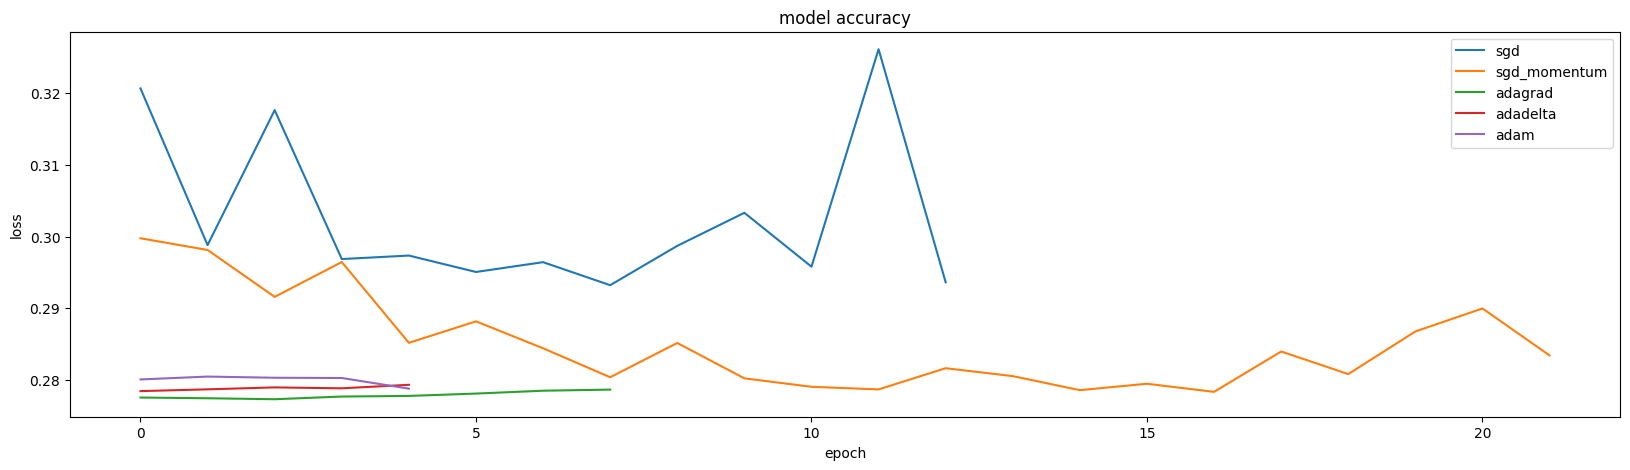

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    multi_disease_model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    
    history = multi_disease_model.fit(x_train, y_train, validation_data = (x_test, y_test), 
                                  epochs = 50, 
                                  callbacks = callbacks_list)
      
    
    plt.plot(history.history['val_loss'])
    
plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

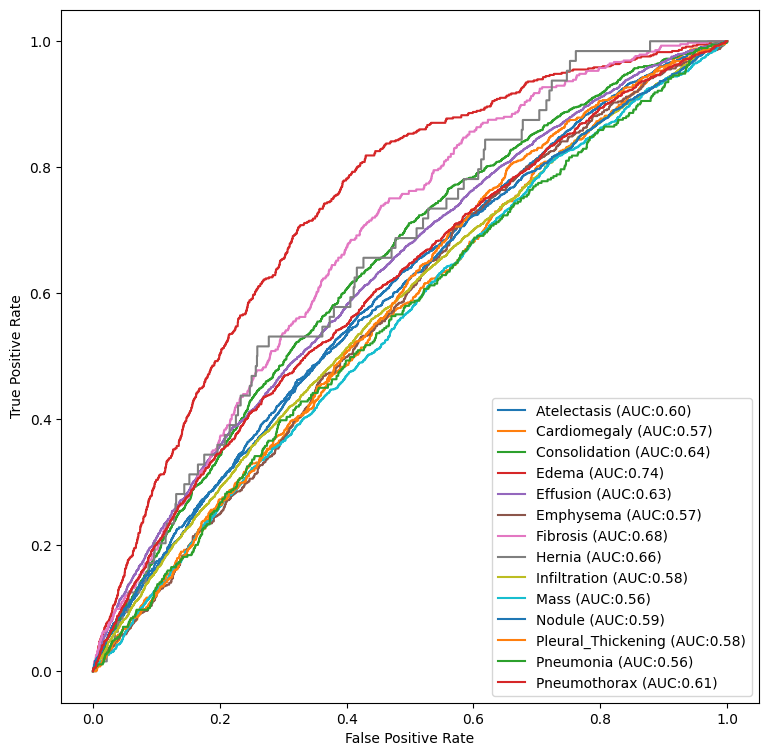

In [40]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [27]:
mobileNet_history = multi_disease_model.fit(x_train, y_train, validation_data = (x_test, y_test), 
                                  epochs = 50,
                                  callbacks = callbacks_list)

Epoch 1/50
1210/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9244 - loss: 0.1954 - mae: 0.1135
Epoch 1: val_loss did not improve from 0.30443
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - binary_accuracy: 0.9244 - loss: 0.1954 - mae: 0.1135 - val_binary_accuracy: 0.8811 - val_loss: 0.3224 - val_mae: 0.1583
Epoch 2/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9259 - loss: 0.1921 - mae: 0.1120
Epoch 2: val_loss did not improve from 0.30443
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - binary_accuracy: 0.9259 - loss: 0.1921 - mae: 0.1120 - val_binary_accuracy: 0.8802 - val_loss: 0.3217 - val_mae: 0.1558
Epoch 3/50
1212/1214 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9293 - loss: 0.1850 - mae: 0.1074
Epoch 3: val_loss did not improve from 0.30443
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - binary_accuracy: 0.9293 - loss: 0.1850 - mae: 0.1074 - val_binary_accuracy: 0.8775 - val_loss: 0.3326 - val_mae: 0.1571
Epoch 4/50
1214/1214 ━━━━━━━

In [34]:
import pickle

# Specify the path where you want to save the history
history_path = '/kaggle/working/mobileNet_history.pkl'

# Save the history
with open(history_path, 'wb') as f:
    pickle.dump(mobileNet_history.history, f)

## ELM

In [24]:
#from sklearn_extensions.extreme_learning_machines.elm import ELMClassifier
from elm import ELMClassifier
from sklearn.preprocessing import StandardScaler

# Assuming x_train and y_train are your training data and labels

# Preprocess the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Create the ELM model
elm_model = ELMClassifier()
elm_model.fit(x_train_scaled, y_train)

# Optionally, you can evaluate the model on test data
# Assuming x_test is your test data
x_test_scaled = scaler.transform(x_test)
predictions = elm_model.predict(x_test_scaled)

ModuleNotFoundError: No module named 'elm'

In [31]:
!pip install git+https://github.com/DEAP/deap

  Cloning https://github.com/DEAP/deap to /tmp/pip-req-build-hks0jrc9
  Running command git clone --filter=blob:none --quiet https://github.com/DEAP/deap /tmp/pip-req-build-hks0jrc9
  Resolved https://github.com/DEAP/deap to commit 028516b63af193580d442e9518a0355136ee60c5
  Preparing metadata (setup.py) ... done
  Created wheel for deap: filename=deap-1.4.1-cp310-cp310-linux_x86_64.whl size=105657 sha256=11cbb4c2313a352870d566ba2446de83e81ec6a78682a4b2e373419fa0659d99
  Stored in directory: /tmp/pip-ephem-wheel-cache-aeq7gttz/wheels/44/1e/24/ab65e27e6e3a19a87c65c9f8a222033f16cd28b192026bd2d5
Successfully built deap
  Attempting uninstall: deap
    Found existing installation: deap 1.3.1
    Uninstalling deap-1.3.1:
      Successfully uninstalled deap-1.3.1


In [33]:
!pip install pyelm

In [34]:
from pyelm import ELM
from sklearn.preprocessing import StandardScaler

# Assuming x_train and y_train are your training data and labels

# Preprocess the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Create the ELM model
elm_model = ELM()
elm_history = elm_model.fit(x_train_scaled, y_train)

# Optionally, you can evaluate the model on test data
# Assuming x_test is your test data
# x_test_scaled = scaler.transform(x_test)
# predictions = elm_model.predict(x_test_scaled)

ImportError: cannot import name 'ELM' from 'pyelm' (/opt/conda/lib/python3.10/site-packages/pyelm/__init__.py)

In [68]:
from sklearn.preprocessing import StandardScaler
from elm import ExtremeLearningMachine

# Assuming x_train, y_train, x_test, y_test are your training and test data
# x_train and x_test are numpy arrays of images
# y_train and y_test are numpy arrays of one-hot encoded labels

# Now that images are loaded and processed, you can fit StandardScaler and transform the data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_flat = scaler.transform(x_test.reshape(x_test.shape[0], -1))

# Create an ELM model
elm_model = ExtremeLearningMachine(n_hidden=500, activation='sigmoid')  # Specify the number of hidden neurons and activation function

# Train the ELM model
elm_history = elm_model.fit(x_train_flat, y_train)

ImportError: cannot import name 'ExtremeLearningMachine' from 'elm' (unknown location)

In [54]:
!git clone https://github.com/5663015/elm

Cloning into 'elm'...
remote: Enumerating objects: 98, done.
remote: Total 98 (delta 0), reused 0 (delta 0), pack-reused 98
Unpacking objects: 100% (98/98), 63.60 KiB | 1.93 MiB/s, done.


In [58]:
!pip install git+https://github.com/5663015/elm.git

  Cloning https://github.com/5663015/elm.git to /tmp/pip-req-build-d_la7yaa
  Running command git clone --filter=blob:none --quiet https://github.com/5663015/elm.git /tmp/pip-req-build-d_la7yaa
  Resolved https://github.com/5663015/elm.git to commit 0d6eca53b964e3354722e782c0f2b636f605ce82
  Preparing metadata (setup.py) ... done


In [63]:
!python /kaggle/working/elm/setup.py install

/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/py

In [64]:
import elm

In [70]:
from sklearn.preprocessing import StandardScaler
from elm import ELMClassifier

# Assuming x_train, y_train are your training data and labels
# x_train should be a numpy array of images, with dimensions (num_samples, height, width, channels)
# y_train should be a numpy array of labels, with dimensions (num_samples, num_labels)

# Reshape and scale the input data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train.reshape(x_train.shape[0], -1))

# Create and train the ELM classifier
elm_model = ELMClassifier(n_hidden=500, activation='sigmoid')
elm_model.fit(x_train_flat, y_train)

ImportError: cannot import name 'ELMClassifier' from 'elm' (unknown location)

In [146]:
y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])